# Model 3

In [18]:
# Import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Statistical Visualization
import seaborn as sns

# Classification or Regression imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

#Model Selection Specific

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [19]:
matches_df = pd.read_csv('../data/matches.csv')
deliveries_df = pd.read_csv('../data/deliveries.csv')
matches_df_dummy = matches_df[['id','team1', 'team2','toss_winner','toss_decision','win_by_runs','win_by_wickets','winner','result']]
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


# Calculate the Inning 1 and Inning 2 scores

In [20]:
deliveries_inning_df = deliveries_df.groupby(['match_id','batting_team','inning']).agg({"total_runs": "sum"})
deliveries_inning_df.head(15)
Deliveries_updated_inning = deliveries_inning_df.groupby(['match_id', 'inning']).agg({"total_runs": "max"})
df3 = Deliveries_updated_inning.unstack(level='inning')
df3.drop(df3.columns[[2,3]], axis=1, inplace=True)
df3.columns = ['Inning_1', 'Inning_2']
df3.head()

,Inning_1,Inning_2
match_id,,
1,207.0,172.0
2,184.0,187.0
3,183.0,184.0
4,163.0,164.0
5,157.0,142.0


# Merge the two DataFrames

In [21]:
a= df3.reset_index()
a.head(10)
merged_df = pd.merge(left=matches_df_dummy,right=a, how='left', left_on='id', right_on='match_id')
# merged_df = DataFrame(index = idx, data =([1,2,3]))
merged_df.head()

,id,team1,team2,toss_winner,toss_decision,win_by_runs,win_by_wickets,winner,result,match_id,Inning_1,Inning_2
0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,35,0,Sunrisers Hyderabad,normal,1,207.0,172.0
1,2,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,0,7,Rising Pune Supergiant,normal,2,184.0,187.0
2,3,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,0,10,Kolkata Knight Riders,normal,3,183.0,184.0
3,4,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,0,6,Kings XI Punjab,normal,4,163.0,164.0
4,5,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,15,0,Royal Challengers Bangalore,normal,5,157.0,142.0


In [22]:
merged_df.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
                 'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
                 'Sunrisers Hyderabad','Rising Pune Supergiants','Rising Pune Supergiant','Kochi Tuskers Kerala','Pune Warriors']
                ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','RPS','KTK','PW'],inplace=True)

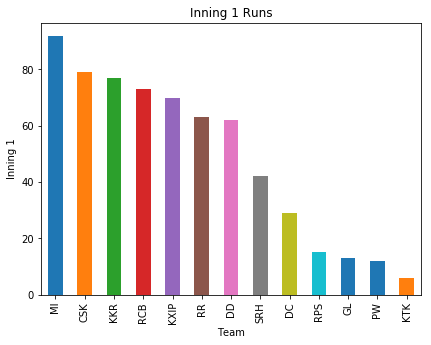

In [23]:
Inning_1 = merged_df['Inning_1'].value_counts()
winner = merged_df['winner'].value_counts()

fig = plt.figure(figsize=(15,5))

A = fig.add_subplot(121)
A.set_xlabel('Team')
A.set_ylabel('Inning 1')
A.set_title("Inning 1 Runs")
winner.plot(kind = 'bar')

# PreProcessing

In [24]:
le = LabelEncoder()
matches_valid_result = merged_df[merged_df['result'] == 'normal']
matches_valid_result.head()
matches_encoded = matches_valid_result.apply(le.fit_transform)

In [25]:
y = matches_valid_result['winner']
x = matches_encoded.drop(['winner'], axis=1)
x.head()

,id,team1,team2,toss_winner,toss_decision,win_by_runs,win_by_wickets,result,match_id,Inning_1,Inning_2
0,0,12,9,9,1,35,0,0,0,118,99
1,1,7,10,10,1,0,7,0,1,95,113
2,2,3,4,4,1,0,10,0,2,94,110
3,3,10,6,6,1,0,6,0,3,74,91
4,4,9,2,9,0,15,0,0,4,68,69


In [26]:
ohe = OneHotEncoder()
onehot_encoded = ohe.fit_transform(x)

# Model

In [27]:
models = []

models.append(("Logistic Regression:", LogisticRegression()))
models.append(("K-Nearest Neighbour:", KNeighborsClassifier(n_neighbors=3)))
models.append(("Decision Tree Classifier:", DecisionTreeClassifier()))
models.append(("Random Forest Classifier:", RandomForestClassifier(n_estimators=64)))
models.append(("MLP:", MLPClassifier(hidden_layer_sizes=(45,30,15),solver='sgd',learning_rate_init=0.01,max_iter=500)))
models.append(("GradientBoostingClassifier:", GradientBoostingClassifier()))
models.append(("SVC:", SVC(kernel = 'rbf', random_state = 0)))

print('Models appended...')

Models appended...


In [28]:
def run_models():
    results = []
    names = []
    for name,model in models:
        cv_result = cross_val_score(model, onehot_encoded, y, cv = 10, scoring = "accuracy")
        names.append(name)
        results.append(cv_result)
    for i in range(len(names)):
        print(names[i],results[i].mean()*100)

In [29]:
run_models()

Logistic Regression: 57.0284146768
K-Nearest Neighbour: 77.0334296067
Decision Tree Classifier: 86.1777562576
Random Forest Classifier: 91.2868927317
MLP: 71.4340503064
GradientBoostingClassifier: 97.840260627
SVC: 14.5666417043


# Analysis

We have used Inning 1 aggregated score and Inning 2 score to predict winner. GradientBoostingClassifier gives us the accuracy of 97.99